# Calibrate 4D STEM rotation and handedness

This notebook uses the defocus method together with a digital twin to adjust the rotation and handedness of a 4D STEM setup. The detector images in a strongly defocused 4D STEM dataset are superimposed. If the parameters of a digital twin match the microscope parameters, the images are correctly superimposed to generate an image of the specimen. If not, the superimposed image is blurred.

This notebook requires `libertem[bqplot]`, `jupyter-ui-poll` and `ipywidgets`.

In [1]:
import numpy as np
import ipywidgets
from jupyter_ui_poll import ui_events
from skimage.measure import blur_effect
from temgymbasic.plotting import plot_model, PlotParams

from libertem.api import Context
from libertem.udf.sum import SumUDF
from libertem.viz.bqp import BQLive2DPlot

from microscope_calibration.udf.stem_overfocus import OverfocusUDF, OverfocusParams
from microscope_calibration.common.stem_overfocus import make_model
from microscope_calibration.util.optimize import make_overfocus_loss_function, optimize

In [2]:
# Default LiberTEM Context with best performance for offline data.
# It may not work within Apptainer images if /dev/shm is not available.
# since this is required for Python multiprocessing.
# ctx = Context()

# Compatible with running inside an Apptainer image
ctx = Context.make_with('threads')

## Load data

The demo file `fourdstem_overfocused.npy` can be generated with the `generate.ipynb` notebook. You can specify use your own dataset in a format that LiberTEM supports. See https://libertem.github.io/LiberTEM/formats.html#supported-formats for supported file formats.

For live processing see https://libertem.github.io/LiberTEM-live/

In [3]:
# Use simulated test dataset
ds = ctx.load('auto', path='fourdstem_overfocused.npy')

# Use the dataset from https://doi.org/10.5281/zenodo.10418769
# Adjust path as needed
#ds = ctx.load('auto', path=r'C:/Users/weber/Nextcloud3/ER-C-Data/adhoc/livecalibration/20221025_154811/rotation_calibration.hdr')

## Set starting values

Set sensible starting values based on your known microscope parameters. Note that the values here don't match the values for fourdstem_overfocused.npy or the measured data so that the adjustment procedure can be tested.

In [4]:
overfocus_params = OverfocusParams(
    overfocus=0.0015,  # m
    scan_pixel_size=0.000001,  # m
    camera_length=0.15,  # m
    detector_pixel_size=0.000050,  # m
    semiconv=0.020,  # rad
    scan_rotation=330.,
    flip_y=False,
    # Offset to avoid subchip gap in butted detectors
    cy=ds.shape.sig[0] / 2 - 2,
    cx=ds.shape.sig[1] / 2 - 2,
)

In [5]:
keep_running = True
def on_click(btn):
    global keep_running
    keep_running = False
    btn.description = '👍 stopping'

stop_btn = ipywidgets.Button(description='Stop series')
stop_btn.on_click(on_click)

In [6]:
test_params = overfocus_params.copy()

In [7]:
overfocus_udf = OverfocusUDF(
    overfocus_params=test_params.copy(),
)
sum_udf = SumUDF()

point_plot = BQLive2DPlot(dataset=ds, udf=overfocus_udf, channel='point')
shifted_sum_plot = BQLive2DPlot(dataset=ds, udf=overfocus_udf, channel='shifted_sum')
sum_plot_plain = BQLive2DPlot(dataset=ds, udf=sum_udf, channel='intensity')
sum_plot = BQLive2DPlot(dataset=ds, udf=overfocus_udf, channel='sum')
selected_plot = BQLive2DPlot(dataset=ds, udf=overfocus_udf, channel='selected')

plots = (point_plot, shifted_sum_plot, sum_plot_plain, selected_plot, sum_plot, )

adjustment_outputs = []

for p in plots:
    # Capture the plots to display them in a grid later
    output = ipywidgets.Output()
    with output:
        p.display()
        # Some plot-specific tweaks for grid display
        if isinstance(p, BQLive2DPlot):
            p.figure.fig_margin={'top': 50, 'bottom': 0, 'left': 25, 'right': 25}
            p.figure.layout.width = '250px'
            p.figure.layout.height = '250px'
    adjustment_outputs.append(output)

rp = test_params

# Create input and output widgets
scan_rotation = ipywidgets.FloatSlider(min=0, max=360, description='Scan rotation / deg', value=rp['scan_rotation'])
flip_y = ipywidgets.Checkbox(description='Flip detector Y axis', value=rp['flip_y'])
overfocus = ipywidgets.FloatText(description='Overfocus / m', value=rp['overfocus'])
camera_length = ipywidgets.FloatText(description='Camera length / m', value=rp['camera_length'])
detector_pixel_size = ipywidgets.FloatText(description='Detector pixel size / m', value=rp['detector_pixel_size'])
scan_pixel_size = ipywidgets.FloatText(description='Scan pixel size / m', value=rp['scan_pixel_size'])
blur = ipywidgets.FloatText(description='Blur metric', value=0, disabled=True)

# Functions to update params and widgets
def update_blur(udf_result):
    blur.value = blur_effect(udf_result['shifted_sum'].data)

def params_to_input(params):
    tp = params
    scan_rotation.value = tp['scan_rotation']
    flip_y.value = tp['flip_y']
    overfocus.value = tp['overfocus']
    camera_length.value = tp['camera_length']
    detector_pixel_size.value = tp['detector_pixel_size']
    scan_pixel_size.value = tp['scan_pixel_size']

def input_to_params(params):
    tp = params
    tp['scan_rotation'] = scan_rotation.value
    tp['flip_y'] = flip_y.value
    tp['overfocus'] = overfocus.value
    tp['camera_length'] = camera_length.value
    tp['detector_pixel_size'] = detector_pixel_size.value
    tp['scan_pixel_size'] = scan_pixel_size.value

# Arrange and display widgets
ipywidgets.VBox([
    ipywidgets.HBox(adjustment_outputs[0:3]),
    ipywidgets.HBox(adjustment_outputs[3:6]),
    ipywidgets.HBox([scan_rotation, blur]),
    flip_y,
    ipywidgets.HBox([overfocus, camera_length]),
    ipywidgets.HBox([detector_pixel_size, scan_pixel_size]),
    stop_btn
])

## Usage

First, adjust scan rotation, flip_y and overfocus in such a way that the "OverfocusUDF: selected" panel shows a recognizable feature of the object in the same size and orientation as "OverfocusUDF: point" panel. "OverfocusUDF: shifted_sum" should start showing a blurred version of "OverfocusUDF: point". Then optimize the parameters until "OverfocusUDF: shifted_sum" appears sharp and the blur metric is minimized.

You can stop the repeated processing with the "Stop series" button at the bottom of the controls.

In [8]:
with ui_events() as poll:
    keep_running = True
    stop_btn.description = 'Stop series'
    params_to_input(test_params)
    while keep_running:
        result_iter = ctx.run_udf_iter(dataset=ds, udf=(overfocus_udf, sum_udf), plots=plots)
        for adjustment_res in result_iter:
            input_to_params(test_params)
            result_iter.update_parameters_experimental([
                {'overfocus_params': test_params},
                {}
            ])
            poll(100)
        update_blur(adjustment_res.buffers[0])
    stop_btn.description = 'Stopped'

## Numerical optimization

After adjusting the parameters manually, you can further refine the result with numerical optimization. This also updates the plots and input elements of the live plot above.

Please note that it doesn't work well with the simulated example data. The experimental dataset works better.

In [9]:
%%time
def my_callback(args, params: OverfocusParams, res, blur):
    print(args, 'loss', blur, 'scan_rotation', params['scan_rotation'], 'overfocus', params['overfocus'])
    update_blur(res[0])
    params_to_input(params)

make_new_params, loss = make_overfocus_loss_function(
    params=test_params,
    ctx=ctx,
    dataset=ds,
    overfocus_udf=overfocus_udf,
    extra_udfs=(sum_udf, ),
    callback=my_callback,
    plots=plots
)
opt_res = optimize(loss)
print(opt_res)
new_params = make_new_params(opt_res.x)
test_params.update(new_params)

[0. 0.] loss 0.33090615 scan_rotation 36.8 overfocus 0.001
[-10.  10.] loss 0.4506146 scan_rotation 26.799999999999997 overfocus 0.00125
[-10. -10.] loss 0.40948784 scan_rotation 26.799999999999997 overfocus 0.00075
[10. 10.] loss 0.43503198 scan_rotation 46.8 overfocus 0.00125
[ 10. -10.] loss 0.39679593 scan_rotation 46.8 overfocus 0.00075
[0. 0.] loss 0.33090615 scan_rotation 36.8 overfocus 0.001
[1. 0.] loss 0.33091488 scan_rotation 37.8 overfocus 0.001
[0. 1.] loss 0.3307775 scan_rotation 36.8 overfocus 0.001025
[-0.06771542  1.99770468] loss 0.33506528 scan_rotation 36.73228457950865 overfocus 0.0010499426169164805
[-0.03385771  1.49885234] loss 0.33168203 scan_rotation 36.76614228975432 overfocus 0.0010374713084582404
[-0.24942617  0.98307114] loss 0.33073044 scan_rotation 36.55057383083519 overfocus 0.001024576778621929
[-0.26737678  0.48339347] loss 0.3308296 scan_rotation 36.532623216855775 overfocus 0.0010120848368328757
[-0.42486214  1.16117847] loss 0.33111203 scan_rotatio

## Show the beam path in the TEMGYM Basic model

The model is scaled to make the beam path recognizable.

{'overfocus': 0.001024576778621929, 'scan_pixel_size': 1e-06, 'camera_length': 0.15, 'detector_pixel_size': 5e-05, 'semiconv': 0.02, 'scan_rotation': 36.55057383083519, 'flip_y': False, 'cy': 30.0, 'cx': 30.0}


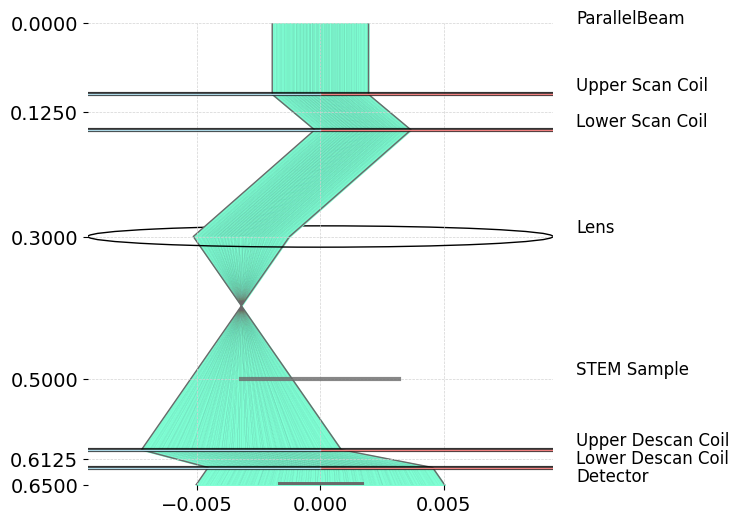

In [10]:
exaggerated_params = test_params.copy()
print(exaggerated_params)
exaggerated_params['scan_pixel_size'] *= 1e2
exaggerated_params['overfocus'] *= 1e2
model = make_model(exaggerated_params, ds.shape)
plot_params = PlotParams(extent_scale=1.1)
fig, ax = plot_model(model, plot_params=plot_params)

In [11]:
fig.savefig('visualization.svg')